# NBA Winner Classifier

## Imports

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.game_matchup as gm
import utils_nba_winner_clf as utils_exp
import qgrid
from yellowbrick import classifier, features
from pandas_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

## Setup

In [35]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

sns.set(style="whitegrid", palette="husl")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Utils functions

In [36]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

In [37]:
def plot_results(experiment_name, results, figsize=(20,10)):
    plt.figure(figsize=figsize)
    results_df = utils.map_results_to_df(results)
    a = sns.pointplot(data=results_df,
              kind="point", x="season_test", y="bal_acc", hue="model"
              )
    a.set_title(
        f"{experiment_name}-bal_acc")
    a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [38]:
def get_results_df():
    return pd.DataFrame(utils_exp.exp_results)

In [39]:
metrics = ['precision', 'balanced_accuracy', 'recall', 'f1', 'roc_auc']

def print_prettier_exp_results(exp_name, metric='roc_auc'):
    ba_df = get_results_df()[['exp_name', 'model',
       f'{metric}_mean', f'{metric}_std']]
    return ba_df[ba_df.exp_name == exp_name].sort_values(by=[f"{metric}_mean"], ascending=False)

## Load Dataset

In [40]:
gm_df = gm.load_game_matchup_dataset()

## EDA

In [17]:
eda_df = gm_df

In [18]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19398 entries, 20300001 to 21801230
Data columns (total 69 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   GAME_DATE_EST          19398 non-null  datetime64[ns]
 1   HOME_TEAM_NAME         19398 non-null  object        
 2   HOME_TEAM_ID           19398 non-null  int64         
 3   VISITOR_TEAM_NAME      19398 non-null  object        
 4   VISITOR_TEAM_ID        19398 non-null  int64         
 5   SEASON                 19398 non-null  int64         
 6   HT_RANK                19398 non-null  int64         
 7   HT_CLASS               19398 non-null  int64         
 8   HT_HW                  19398 non-null  int64         
 9   HT_HL                  19398 non-null  int64         
 10  HT_VW                  19398 non-null  int64         
 11  HT_VL                  19398 non-null  int64         
 12  HT_LAST10_W            19398 non-null  int64      

In [19]:
eda_df.describe()

HOME_TEAM_ID  VISITOR_TEAM_ID        SEASON       HT_RANK  \
count  1.939800e+04     1.939800e+04  19398.000000  19398.000000   
mean   1.610613e+09     1.610613e+09   2010.509589     14.616094   
std    8.638752e+00     8.639274e+00      4.630101      8.633493   
min    1.610613e+09     1.610613e+09   2003.000000      0.000000   
25%    1.610613e+09     1.610613e+09   2006.000000      7.000000   
50%    1.610613e+09     1.610613e+09   2010.000000     15.000000   
75%    1.610613e+09     1.610613e+09   2015.000000     22.000000   
max    1.610613e+09     1.610613e+09   2018.000000     29.000000   

           HT_CLASS         HT_HW         HT_HL         HT_VW         HT_VL  \
count  19398.000000  19398.000000  19398.000000  19398.000000  19398.000000   
mean       1.009125     11.744407      8.050418      8.238169     12.046448   
std        0.814665      8.074168      6.217595      6.203820      8.107570   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      5.000000      3.000000      3.000000      5.000000   
50%        1.000000     11.000000      7.000000      7.000000     11.000000   
75%        2.000000     18.000000     12.000000     12.000000     18.000000   
max        2.000000     39.000000     33.000000     34.000000     37.000000   

        HT_LAST10_W  ...  FG3_PCT_home      AST_home      REB_home  \
count  19398.000000  ...   19398.00000  19398.000000  19398.000000   
mean       4.643932  ...       0.35717     22.588927     43.089700   
std        2.279641  ...       0.11553      5.151187      6.562873   
min        0.000000  ...       0.00000      6.000000     17.000000   
25%        3.000000  ...       0.28600     19.000000     39.000000   
50%        5.000000  ...       0.35700     22.000000     43.000000   
75%        6.000000  ...       0.42900     26.000000     47.000000   
max       10.000000  ...       1.00000     47.000000     72.000000   

           PTS_away   FG_PCT_away   FT_PCT_away  FG3_PCT_away      AST_away  \
count  19398.000000  19398.000000  19398.000000  19398.000000  19398.000000   
mean      99.052531      0.449619      0.757472      0.350370     21.165584   
std       12.699235      0.055247      0.103019      0.113636      5.058599   
min       54.000000      0.244000      0.143000      0.000000      4.000000   
25%       90.000000      0.413000      0.692000      0.276000     18.000000   
50%       99.000000      0.449000      0.765000      0.350000     21.000000   
75%      107.000000      0.487000      0.828000      0.423000     24.000000   
max      168.000000      0.670000      1.000000      1.000000     46.000000   

           REB_away  HOME_TEAM_WINS  
count  19398.000000    19398.000000  
mean      41.763945        0.594907  
std        6.462570        0.490923  
min       20.000000        0.000000  
25%       37.000000        0.000000  
50%       42.000000        1.000000  
75%       46.000000        1.000000  
max       81.000000        1.000000  

[8 rows x 66 columns]

In [20]:
eda_df["WIN"] = ["HOME" if x == 1 else "VISITOR" for x in eda_df['HOME_TEAM_WINS']]

In [21]:
eda_df["WIN"].value_counts()

HOME       11540
VISITOR     7858
Name: WIN, dtype: int64

### Pandas Profiling

In [22]:
profile = ProfileReport(eda_df, title='Pandas Profiling Report', pool_size=4,
                        minimal=True,
                        explorative=True,
                           correlations={
             "pearson": {"calculate": True},
             "spearman": {"calculate": True},
             "kendall": {"calculate": True},
             "phi_k": {"calculate": False},
             "cramers": {"calculate": False},
         })
profile

### By Team

In [23]:
last_season = eda_df[eda_df.SEASON == 2018]
last_season.head()

GAME_DATE_EST HOME_TEAM_NAME  HOME_TEAM_ID VISITOR_TEAM_NAME  \
GAME_ID                                                                 
21800001    2018-10-16            BOS    1610612738               PHI   
21800002    2018-10-16            GSW    1610612744               OKC   
21800003    2018-10-17            CHA    1610612766               MIL   
21800004    2018-10-17            DET    1610612765               BKN   
21800005    2018-10-17            IND    1610612754               MEM   

          VISITOR_TEAM_ID  SEASON  HT_RANK  HT_CLASS  HT_HW  HT_HL  ...  \
GAME_ID                                                             ...   
21800001       1610612755    2018       29         2      0      0  ...   
21800002       1610612760    2018       28         2      0      0  ...   
21800003       1610612749    2018       16         1      0      0  ...   
21800004       1610612751    2018       20         2      0      0  ...   
21800005       1610612763    2018       26         2      0      0  ...   

          AST_home  REB_home  PTS_away  FG_PCT_away  FT_PCT_away  \
GAME_ID                                                            
21800001      21.0      55.0      87.0        0.391        0.609   
21800002      28.0      58.0     100.0        0.363        0.649   
21800003      21.0      41.0     113.0        0.494        0.750   
21800004      21.0      46.0     100.0        0.488        0.682   
21800005      29.0      57.0      83.0        0.298        0.821   

          FG3_PCT_away  AST_away  REB_away  HOME_TEAM_WINS      WIN  
GAME_ID                                                              
21800001         0.192      18.0      47.0               1     HOME  
21800002         0.270      21.0      45.0               1     HOME  
21800003         0.412      26.0      57.0               0  VISITOR  
21800004         0.185      28.0      39.0               1     HOME  
21800005         0.345      16.0      28.0               1     HOME  

[5 rows x 70 columns]

In [24]:
home_wins_df = last_season[["HOME_TEAM_NAME", "HOME_TEAM_WINS"]].groupby(by="HOME_TEAM_NAME") \
.agg({'HOME_TEAM_NAME':'count', 'HOME_TEAM_WINS': 'sum'}) \
.sort_values(by=["HOME_TEAM_WINS"], ascending=False)
home_wins_df["TEAM_LOSS"] = home_wins_df["HOME_TEAM_NAME"] - home_wins_df["HOME_TEAM_WINS"]
home_wins_df.drop(labels=["HOME_TEAM_NAME"], axis=1, inplace=True)
home_wins_df.rename(columns={"HOME_TEAM_WINS": "TEAM_WINS"}, inplace=True)
home_wins_df.index.rename("TEAM_NAME", inplace=True)
home_wins_df

TEAM_WINS  TEAM_LOSS
TEAM_NAME                      
DEN               34          7
MIL               33          8
SAS               32          9
POR               32          9
TOR               32          9
PHI               31         10
HOU               31         10
GSW               30         11
IND               29         12
UTA               29         12
BOS               28         13
OKC               27         14
DET               26         15
LAC               26         15
CHA               25         16
MIN               25         16
ORL               25         16
DAL               24         17
SAC               24         17
BKN               23         18
LAL               22         19
WAS               22         19
MEM               21         20
MIA               19         22
NOP               19         22
ATL               17         24
CLE               13         28
PHX               12         29
NYK                9         32
CHI                9         32

In [25]:
visitor_wins_df = last_season[["VISITOR_TEAM_NAME", "HOME_TEAM_WINS"]].groupby(by="VISITOR_TEAM_NAME") \
.agg({'VISITOR_TEAM_NAME':'count', 'HOME_TEAM_WINS': 'sum'}) \
.sort_values(by=["HOME_TEAM_WINS"], ascending=False)
visitor_wins_df["TEAM_WINS"] = visitor_wins_df["VISITOR_TEAM_NAME"] - visitor_wins_df["HOME_TEAM_WINS"]
visitor_wins_df.rename(columns={"HOME_TEAM_WINS": "TEAM_LOSS"}, inplace=True)
visitor_wins_df.drop(labels=["VISITOR_TEAM_NAME"], axis=1, inplace=True)
visitor_wins_df.index.rename("TEAM_NAME", inplace=True)
#visitor_wins_df = visitor_wins_df[["TEAM_WINS"]]
visitor_wins_df = visitor_wins_df[["TEAM_WINS", "TEAM_LOSS"]]
visitor_wins_df

TEAM_WINS  TEAM_LOSS
TEAM_NAME                      
CLE                6         35
PHX                7         34
NYK                8         33
DAL                9         32
WAS               10         31
MIN               11         30
MEM               12         29
ATL               12         29
CHI               13         28
CHA               14         27
NOP               14         27
LAL               15         26
SAC               15         26
DET               15         26
SAS               16         25
ORL               17         24
BKN               19         22
IND               19         22
DEN               20         21
PHI               20         21
MIA               20         21
BOS               21         20
POR               21         20
UTA               21         20
LAC               22         19
OKC               22         19
HOU               22         19
TOR               26         15
MIL               27         14
GSW               27         14

In [26]:
home_wins_df.combine(visitor_wins_df, lambda s1, s2: s1 + s2).sort_values(by="TEAM_WINS", ascending=False)

TEAM_WINS  TEAM_LOSS
TEAM_NAME                      
MIL               60         22
TOR               58         24
GSW               57         25
DEN               54         28
HOU               53         29
POR               53         29
PHI               51         31
UTA               50         32
BOS               49         33
OKC               49         33
LAC               48         34
IND               48         34
SAS               48         34
ORL               42         40
BKN               42         40
DET               41         41
MIA               39         43
CHA               39         43
SAC               39         43
LAL               37         45
MIN               36         46
NOP               33         49
MEM               33         49
DAL               33         49
WAS               32         50
ATL               29         53
CHI               22         60
PHX               19         63
CLE               19         63
NYK               17         65

In [27]:
mil_df = last_season[(last_season.VISITOR_TEAM_NAME == 'MIL') | (last_season.HOME_TEAM_NAME == 'MIL')]
mil_df['GAME_N'] = range(1, 83,1)
mil_df

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


GAME_DATE_EST HOME_TEAM_NAME  HOME_TEAM_ID VISITOR_TEAM_NAME  \
GAME_ID                                                                 
21800003    2018-10-17            CHA    1610612766               MIL   
21800023    2018-10-19            MIL    1610612749               IND   
21800042    2018-10-22            MIL    1610612749               NYK   
21800059    2018-10-24            MIL    1610612749               PHI   
21800071    2018-10-26            MIN    1610612750               MIL   
...                ...            ...           ...               ...   
21801154    2019-04-01            BKN    1610612751               MIL   
21801177    2019-04-04            PHI    1610612755               MIL   
21801193    2019-04-06            MIL    1610612749               BKN   
21801202    2019-04-07            MIL    1610612749               ATL   
21801226    2019-04-10            MIL    1610612749               OKC   

          VISITOR_TEAM_ID  SEASON  HT_RANK  HT_CLASS  HT_HW  HT_HL  ...  \
GAME_ID                                                             ...   
21800003       1610612749    2018       16         1      0      0  ...   
21800023       1610612754    2018       24         2      0      0  ...   
21800042       1610612752    2018       27         2      1      0  ...   
21800059       1610612755    2018       27         2      2      0  ...   
21800071       1610612749    2018        7         0      2      0  ...   
...                   ...     ...      ...       ...    ...    ...  ...   
21801154       1610612749    2018       15         1     22     16  ...   
21801177       1610612749    2018       23         2     30      9  ...   
21801193       1610612751    2018       29         2     32      6  ...   
21801202       1610612737    2018       29         2     32      7  ...   
21801226       1610612760    2018       29         2     33      7  ...   

          REB_home  PTS_away  FG_PCT_away  FT_PCT_away  FG3_PCT_away  \
GAME_ID                                                                
21800003      41.0     113.0        0.494        0.750         0.412   
21800023      50.0     101.0        0.437        0.704         0.333   
21800042      55.0     113.0        0.455        0.867         0.345   
21800059      51.0     108.0        0.413        0.700         0.324   
21800071      49.0     125.0        0.533        0.727         0.413   
...            ...       ...          ...          ...           ...   
21801154      55.0     131.0        0.500        0.867         0.324   
21801177      43.0     128.0        0.452        0.744         0.353   
21801193      43.0     133.0        0.495        0.783         0.422   
21801202      61.0     107.0        0.400        0.526         0.378   
21801226      53.0     127.0        0.485        0.615         0.426   

          AST_away  REB_away  HOME_TEAM_WINS      WIN  GAME_N  
GAME_ID                                                        
21800003      26.0      57.0               0  VISITOR       1  
21800023      14.0      41.0               1     HOME       2  
21800042      22.0      43.0               1     HOME       3  
21800059      29.0      50.0               1     HOME       4  
21800071      32.0      62.0               0  VISITOR       5  
...            ...       ...             ...      ...     ...  
21801154      28.0      40.0               0  VISITOR      78  
21801177      26.0      50.0               0  VISITOR      79  
21801193      25.0      43.0               0  VISITOR      80  
21801202      25.0      48.0               1     HOME      81  
21801226      40.0      53.0               0  VISITOR      82  

[82 rows x 71 columns]

In [28]:
#sns.regplot(x=mil_df["GAME_N"], y=mil_df["GAME_N"])
#sns.catplot(data=mil_df[["HOME_TEAM_NAME", "GAME_N", "WIN"]],  x="GAME_N", y="HOME_TEAM_NAME", kind="bar", hue="WIN", palette="Set2")
#sns.displot(data=mil_df, x="GAME_N", hue="WIN", multiple="stack")
#plt.show()


### Scatter plot

## Dataset


In [29]:
gm_df.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [41]:
df = gm_df[gm_df.SEASON >= 2013]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

## Experiments

### Setup

In [42]:
exp_prefix = ""
exp_group_name = "experiments"
results_total = []
utils_exp.exp_results = []
TARGET = "HOME_TEAM_WINS"
exp_X_columns = model_config.X_COLUMNS
exp_y_columns = [TARGET]


models = utils_exp.get_clf_models()

sscv = utils.SeasonSeriesSplit(df)
df_sscv = sscv.get_df()
X = df_sscv[exp_X_columns]
y = df_sscv['HOME_TEAM_WINS']

#utils_exp.exp_results = utils.deserialize_object(exp_group_name)

### Experiment using 1 season

In [46]:
experiment_name = f"{exp_prefix}1_season"

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment 1_season
Done


exp_name model  roc_auc_mean  roc_auc_std
0   1_season   L2R      0.625496     0.021410
7   1_season   L2R      0.625496     0.021410
3   1_season   SVM      0.620807     0.021440
10  1_season   SVM      0.620807     0.021440
1   1_season   KNN      0.604684     0.021737
8   1_season   KNN      0.604684     0.021737
4   1_season    RF      0.602216     0.021163
11  1_season    RF      0.602216     0.021163
5   1_season   XGB      0.575175     0.028171
12  1_season   XGB      0.575175     0.028171
6   1_season   LGB      0.572804     0.024710
13  1_season   LGB      0.572804     0.024710
2   1_season    DT      0.539879     0.014171
9   1_season    DT      0.539879     0.014171

In [47]:
show_qgrid(get_results_df())

- Respecto a la metrica auc_roc se observa lo siguiente:

    - ***SVM***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***XGB***: Obtuvo el segundo promedio mas alto.
    - ***LGB***: Obtuvo el tercer promedio mas alto.

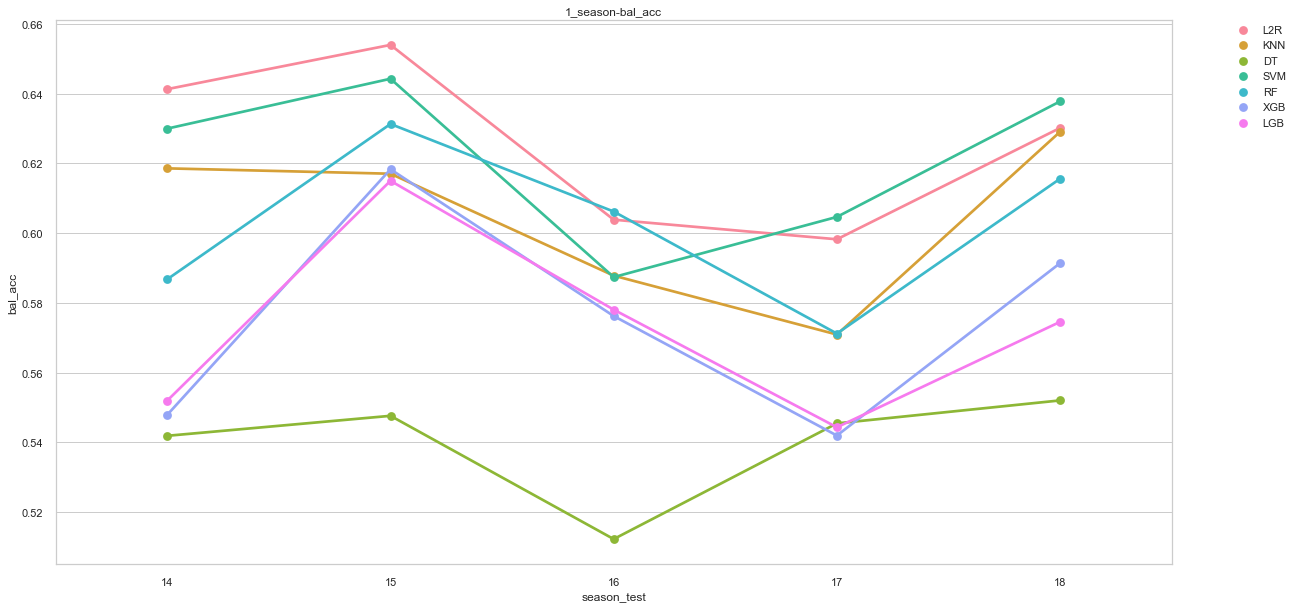

In [48]:
#### Visualize experiments results
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de los resultados del experimento se observa lo siguiente:

    - SVM supero con gran ventaja a los demas algoritmos. El algoritmo XGB fue el que mas cerca estuvo a SVM.
    - Se evidencian los siguientes patrones:
        - Para todos los algoritmos hubo una notable mejoria al ser entrenados con la temporada 2014 para predecir la temporada 2015.
        - Sin embargo en las siguientes validaciones para la temporada 2016 y 2017 nuevamente se evidencia una caida en el rendimiento de todos los algoritmos.
        - Para predecir la temporada 2018 pues este rendimiento mejoro.

### Experiment using StandardScaler

In [49]:
experiment_name = f"{exp_prefix}scaled_data"

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, model_config.X_NUM_COLS)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment scaled_data
Done


exp_name model  roc_auc_mean  roc_auc_std
14  scaled_data   L2R      0.617830     0.016352
15  scaled_data   KNN      0.615818     0.012773
17  scaled_data   SVM      0.614107     0.023296
18  scaled_data    RF      0.605797     0.020663
19  scaled_data   XGB      0.575391     0.028887
20  scaled_data   LGB      0.574401     0.017958
16  scaled_data    DT      0.538306     0.011420

- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***XGB***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***RF***: Obtuvo el segundo promedio mas alto.
    - ***LGB***: Obtuvo el tercer promedio mas alto.

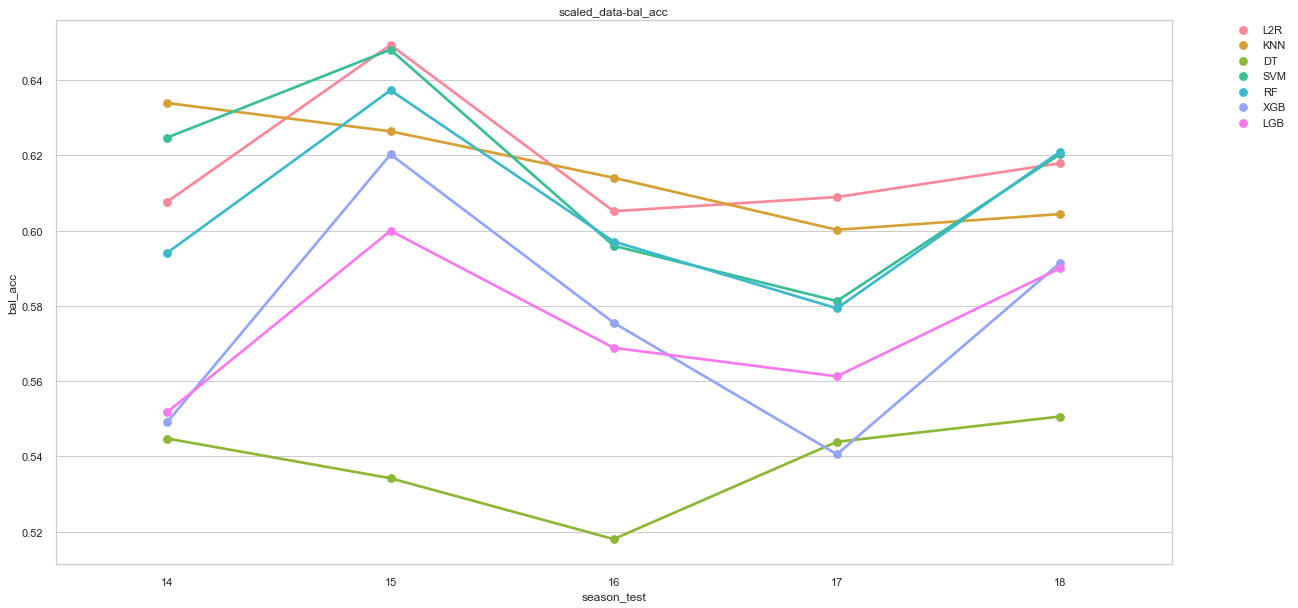

In [50]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de los resultados del experimento se observa lo siguiente:

    - A pesar de que obtuvo el mejor rendimiento en la primera validacion, el algoritmo SVM empeoro en cada validacion. Cabe señalar tambien que ademas de que cayo empicado arrojo un rendimiento de un 50% para la ultima validacion.
    - Para los demas algoritmos se evidencia un patron en la validacion de predecir al temporada 15 donde para todos fue un mejor rendimiento que para predecir la temporada 14.
    - Para la temporada 16 el rendimiento bajo para todos.
    - Para la temporada 17 el algoritmo KNN presenta una notable mejoria por enciman de los demas algoritmos.
    - Para la ultima temporada el algoritmo XGB fue el que obtuvo el mejor rendimiento.

### Experiment: train: 2s; test: 1s

In [51]:
experiment_name = f"{exp_prefix}2_seasons"

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment 2_seasons
Done


exp_name model  roc_auc_mean  roc_auc_std
21  2_seasons   L2R      0.631986     0.015889
24  2_seasons   SVM      0.628659     0.022416
25  2_seasons    RF      0.613714     0.014841
22  2_seasons   KNN      0.604713     0.013914
27  2_seasons   LGB      0.596439     0.009808
26  2_seasons   XGB      0.591056     0.013289
23  2_seasons    DT      0.551507     0.009800

- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***SVM***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***LGB***: Obtuvo el segundo promedio mas alto.
    - ***XGB***: Obtuvo el tercer promedio mas alto.

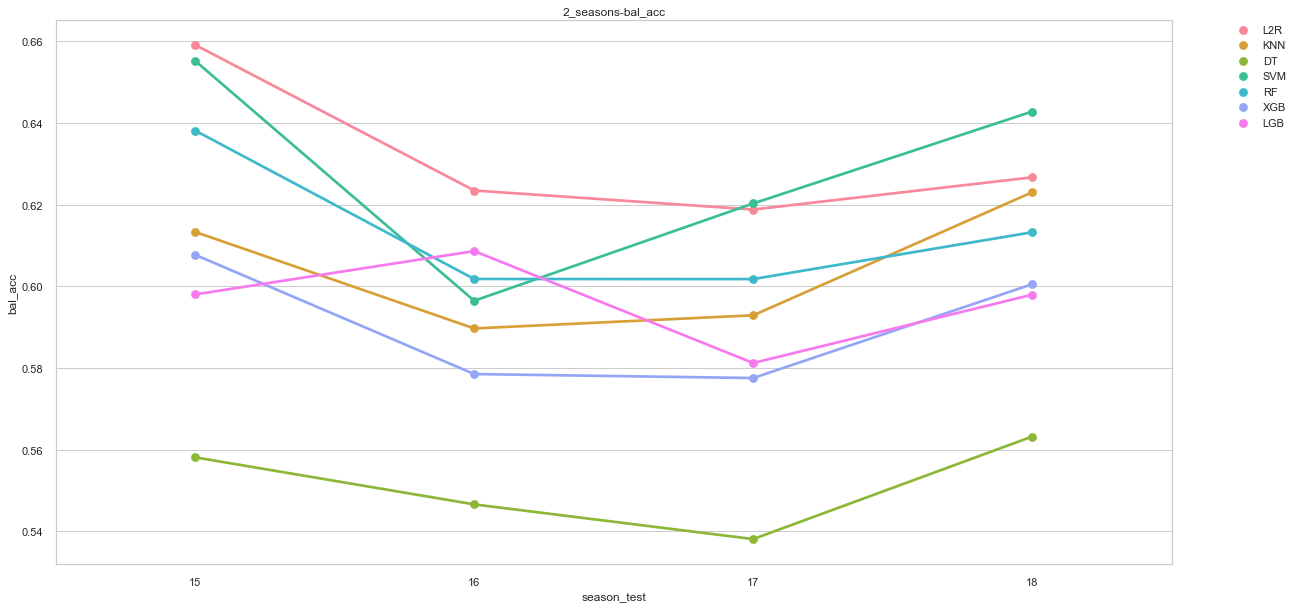

In [52]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de los resultados del experimento se observa lo siguiente:

    - Claramente SVM fue el algoritmo que mejor rendimiento tuvo en cada una de las validaciones.
    - Se evidencia un patron en el que todos los algoritmos tuvieron una caida de su rendimiento en la temporada 16 y continuo cayendo en el 17, a excepcion de RF que mejoro.
    - Otro patron que se evidencia es que para la temporada 2018 todos los algoritmos mejoraron.


### Experiment: train: 3s; test: 1s

In [53]:
experiment_name = f"{exp_prefix}3_seasons"

folds, train_seasons, test_seasons = sscv.split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment 3_seasons
Done


exp_name model  roc_auc_mean  roc_auc_std
31  3_seasons   SVM      0.622315     0.011442
28  3_seasons   L2R      0.620296     0.005331
29  3_seasons   KNN      0.607175     0.013295
32  3_seasons    RF      0.602798     0.005487
34  3_seasons   LGB      0.594491     0.012610
33  3_seasons   XGB      0.586568     0.006295
30  3_seasons    DT      0.538272     0.007686

- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***SVM***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***LGB***: Obtuvo el segundo promedio mas alto.
    - ***XGB***: Obtuvo el tercer promedio mas alto.

 Se destaca tambien que estos resultados son muy similares a los del experimento anterior(2s 1s)

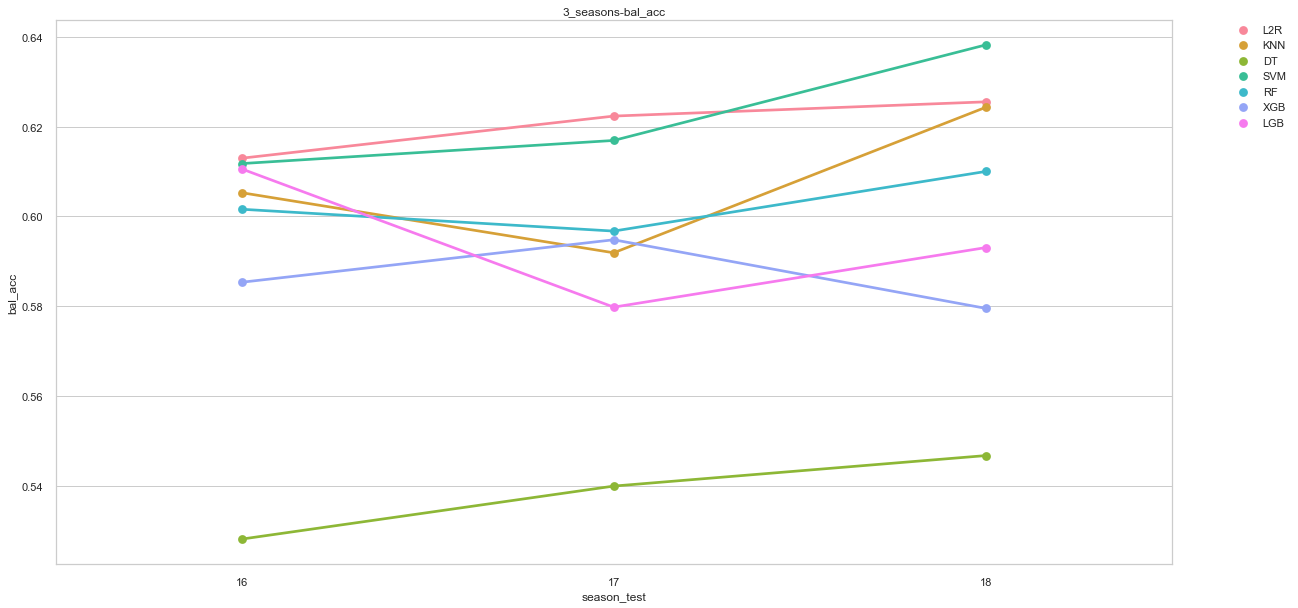

In [54]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de cada validacion se observa lo siguiente:

    - Nuevamente SVM fue el algoritmo que mejor rendimiento tuvo en cada una de las validaciones.
    - Se evidencia un ligero patron de ascenso para los tres algoritmos con mejor rendimiento, lo cual indica cierta estabilidad en las validaciones de este experimento comparada con los experimentos anteriores.
    - Tambien se evidencia que comparado con los experimentos anteriores, en este el peor rendimiento estuvo en la primera validacion la del 16.

### Experiment train: 3q ; test: 1q

In [55]:
experiment_name = f"{exp_prefix}3q_1q"

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment 3q_1q
Done


exp_name model  roc_auc_mean  roc_auc_std
35    3q_1q   L2R      0.629940     0.043293
38    3q_1q   SVM      0.618504     0.046988
39    3q_1q    RF      0.607484     0.049126
36    3q_1q   KNN      0.607346     0.050249
40    3q_1q   XGB      0.590581     0.040677
41    3q_1q   LGB      0.587128     0.047713
37    3q_1q    DT      0.540207     0.030066

- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***LGB***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***KNN***: Obtuvo el segundo promedio mas alto.
    - ***SVM***: Obtuvo el tercer promedio mas alto.

 Comparado con el anterior experimento(3s 1s), estos resultados son peores, pero es importante destacar que se hicieron muchisimas mas validaciones que los experimentos anteriores. Ver grafico debajo.

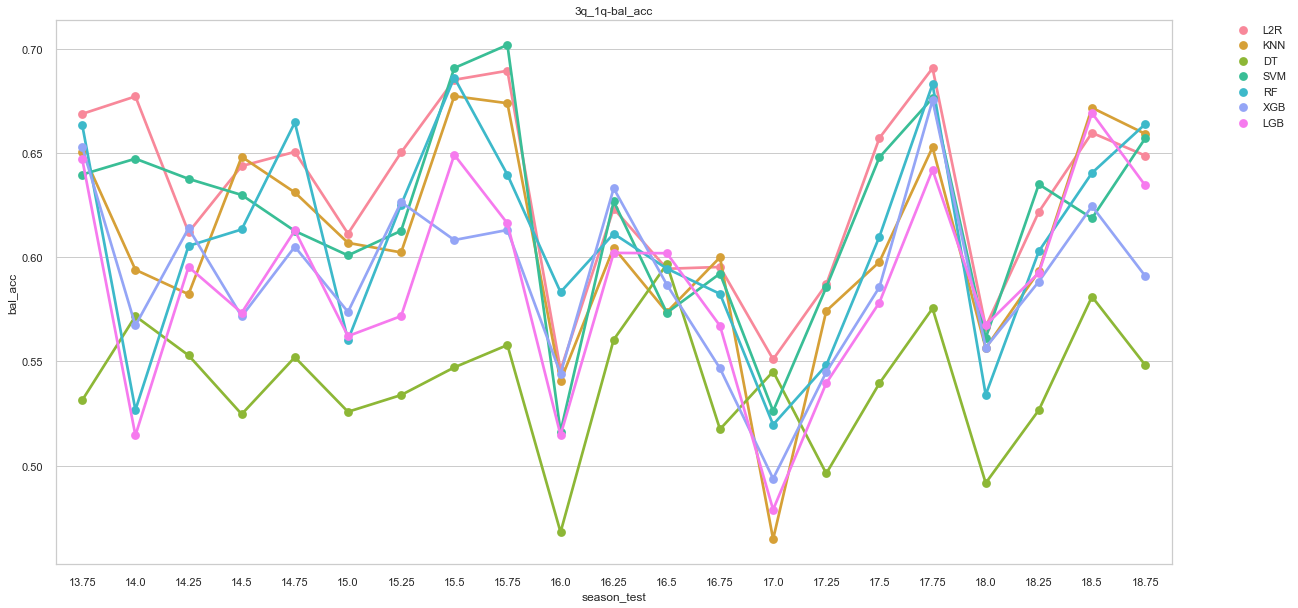

In [56]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de cada validacion se observa lo siguiente:

    - SVM fue bastante inestable, tuvo casi igual de picos de buenos rendimientos como caidas de malos rendientos.
    - Se observa un patron, en cada cuarto de temporada 0.25, que corresponde a la mitad(desde 0.25 a 0.5) pues el rendimiento de cada algoritmo tuvo una caida.

### Experiment train: 4q ; test: 2q

In [57]:
experiment_name = f"{exp_prefix}4q_2q"

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment 4q_2q
Done


exp_name model  roc_auc_mean  roc_auc_std
42    4q_2q   L2R      0.627266     0.031262
45    4q_2q   SVM      0.616196     0.028807
46    4q_2q    RF      0.610245     0.030282
43    4q_2q   KNN      0.604309     0.030807
47    4q_2q   XGB      0.589772     0.032674
48    4q_2q   LGB      0.585987     0.030654
44    4q_2q    DT      0.554209     0.020278

- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***SVM***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***XGB***: Obtuvo el segundo promedio mas alto.
    - ***RF***: Obtuvo el tercer promedio mas alto.


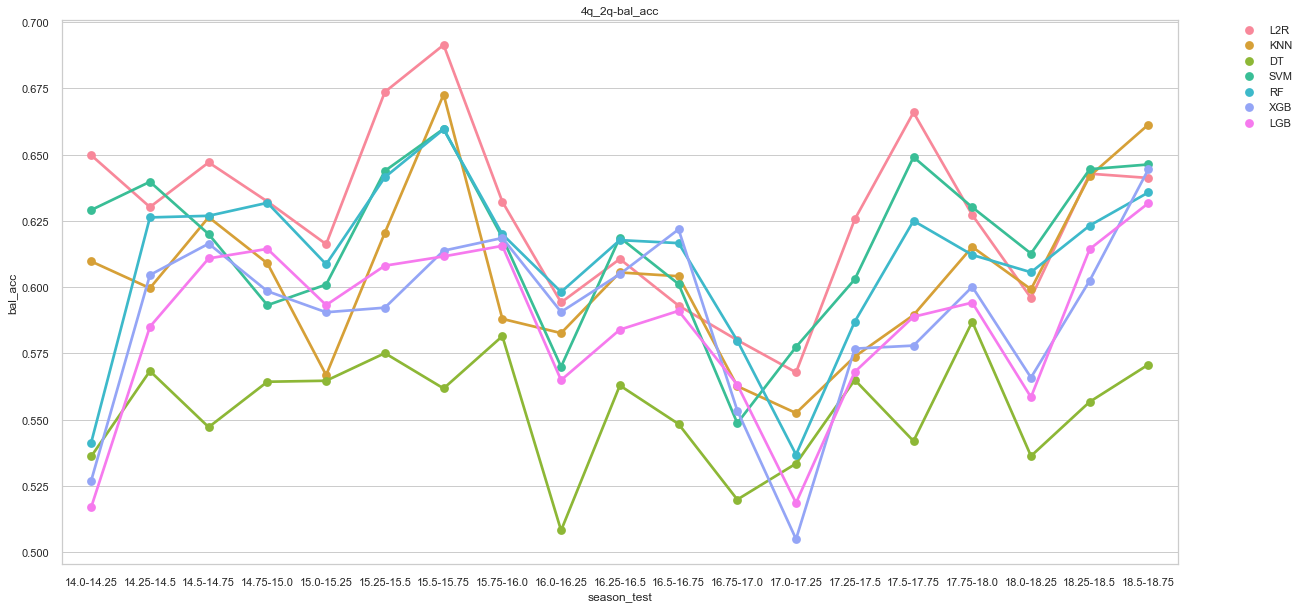

In [58]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de cada validacion se observa lo siguiente:

    - SVM fue un poco mas estable que el experimento anterior.
    - Se observa un patron, en cada validacion 0.5-0.75, es decir, que se trata de predecir la segunda mitad de la temporada, usando la primera mitad de la temporada actual y la ultima mitad de la anterior, pues hay una caida en el rendimiento de los algoritmos.

### Experiment remove first 1q ; train: 2q ; test: 1q

En este experimento se eliminara el primer cuarto de cada temporada, y se entrenara el modelo con los 2 siguientes cuartos, y como test 1 cuarto de temporada. La ventana deslisante sera de 1 cuarto.

In [59]:
experiment_name = f"{exp_prefix}r1q_2q_1q"

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=1, skip=[0.25])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment r1q_2q_1q
Done


exp_name model  roc_auc_mean  roc_auc_std
49  r1q_2q_1q   L2R      0.637905     0.037837
52  r1q_2q_1q   SVM      0.626988     0.039693
50  r1q_2q_1q   KNN      0.621342     0.043038
53  r1q_2q_1q    RF      0.618262     0.043550
55  r1q_2q_1q   LGB      0.595802     0.042701
54  r1q_2q_1q   XGB      0.589279     0.038047
51  r1q_2q_1q    DT      0.544639     0.023134

- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***KNN***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***LGB***: Obtuvo el segundo promedio mas alto.
    - ***SVM***: Obtuvo el tercer promedio mas alto.


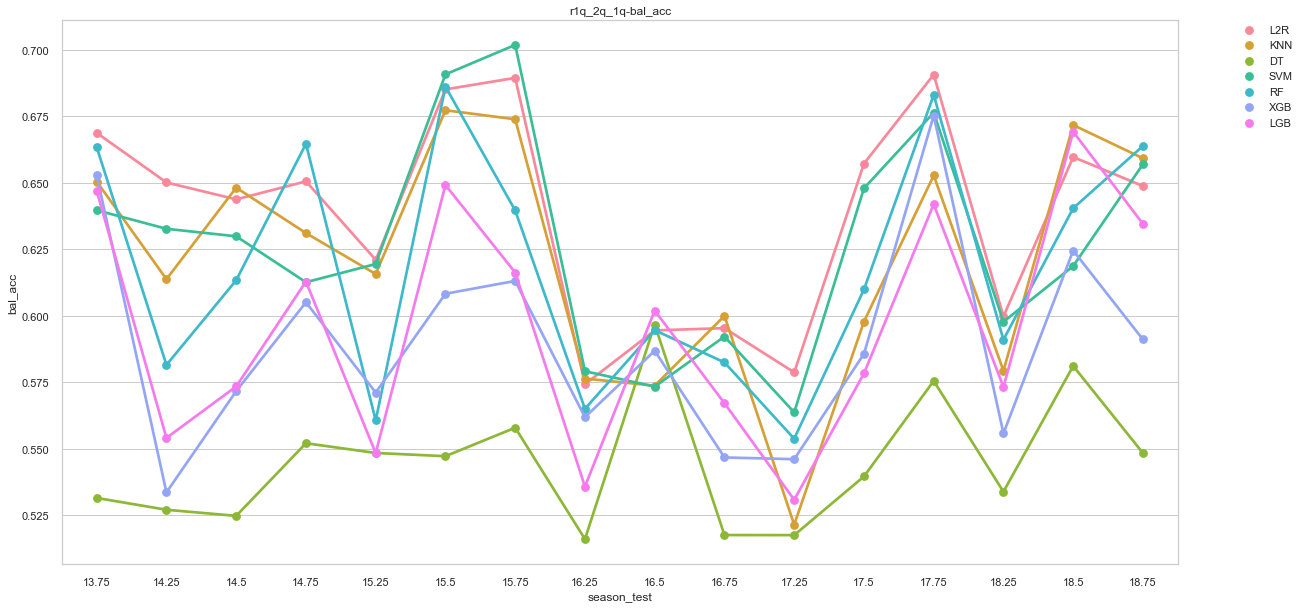

In [60]:
#### Visualize experiments results
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de cada validacion se observa lo siguiente:

    - Se observa un patron, en cada validacion .75, es decir, que se trata de predecir el ultimo cuarto de temporada, pues hay una caida del rendimiento en el caso del algoritmo SVM, sin embargo no es lo mismo para los otros algoritmos, al menos no para todos las validaciones .75.

### Experiments comparison

In [61]:
utils.serialize_object(exp_group_name, utils_exp.exp_results)

In [62]:
exp_df = get_results_df()

In [63]:
# ba_df = exp_df[['exp_name', 'model',
#        'balanced_accuracy_mean', 'balanced_accuracy_std']]

KeyError: "['balanced_accuracy_std', 'balanced_accuracy_mean'] not in index"

In [65]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(exp_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [ ]:
ba_df.sort_values(
    by=["balanced_accuracy_mean"]
    , ascending=False)[:6].reset_index().drop(labels=["index"], axis=1)

Basado en la metrica 'balanced_accuracy_mean' se observa:

- El algoritmo SVM obtuvo el mejor rendimiento para la mayoria de los experimentos. LGB fue el algoritmo siguiente que obtuvo el mejor rendimiento.
- En los experimentos que se obtuvo el mejor rendimiento fueron usando 2 y 3 temporadas para entrenamiento para predecir al siguiente.


#### Plot experiment results

In [20]:
utils.serialize_object("results", utils_exp.exp_results)
utils.serialize_object("results_total", results_total)

#### Balance Accuracy

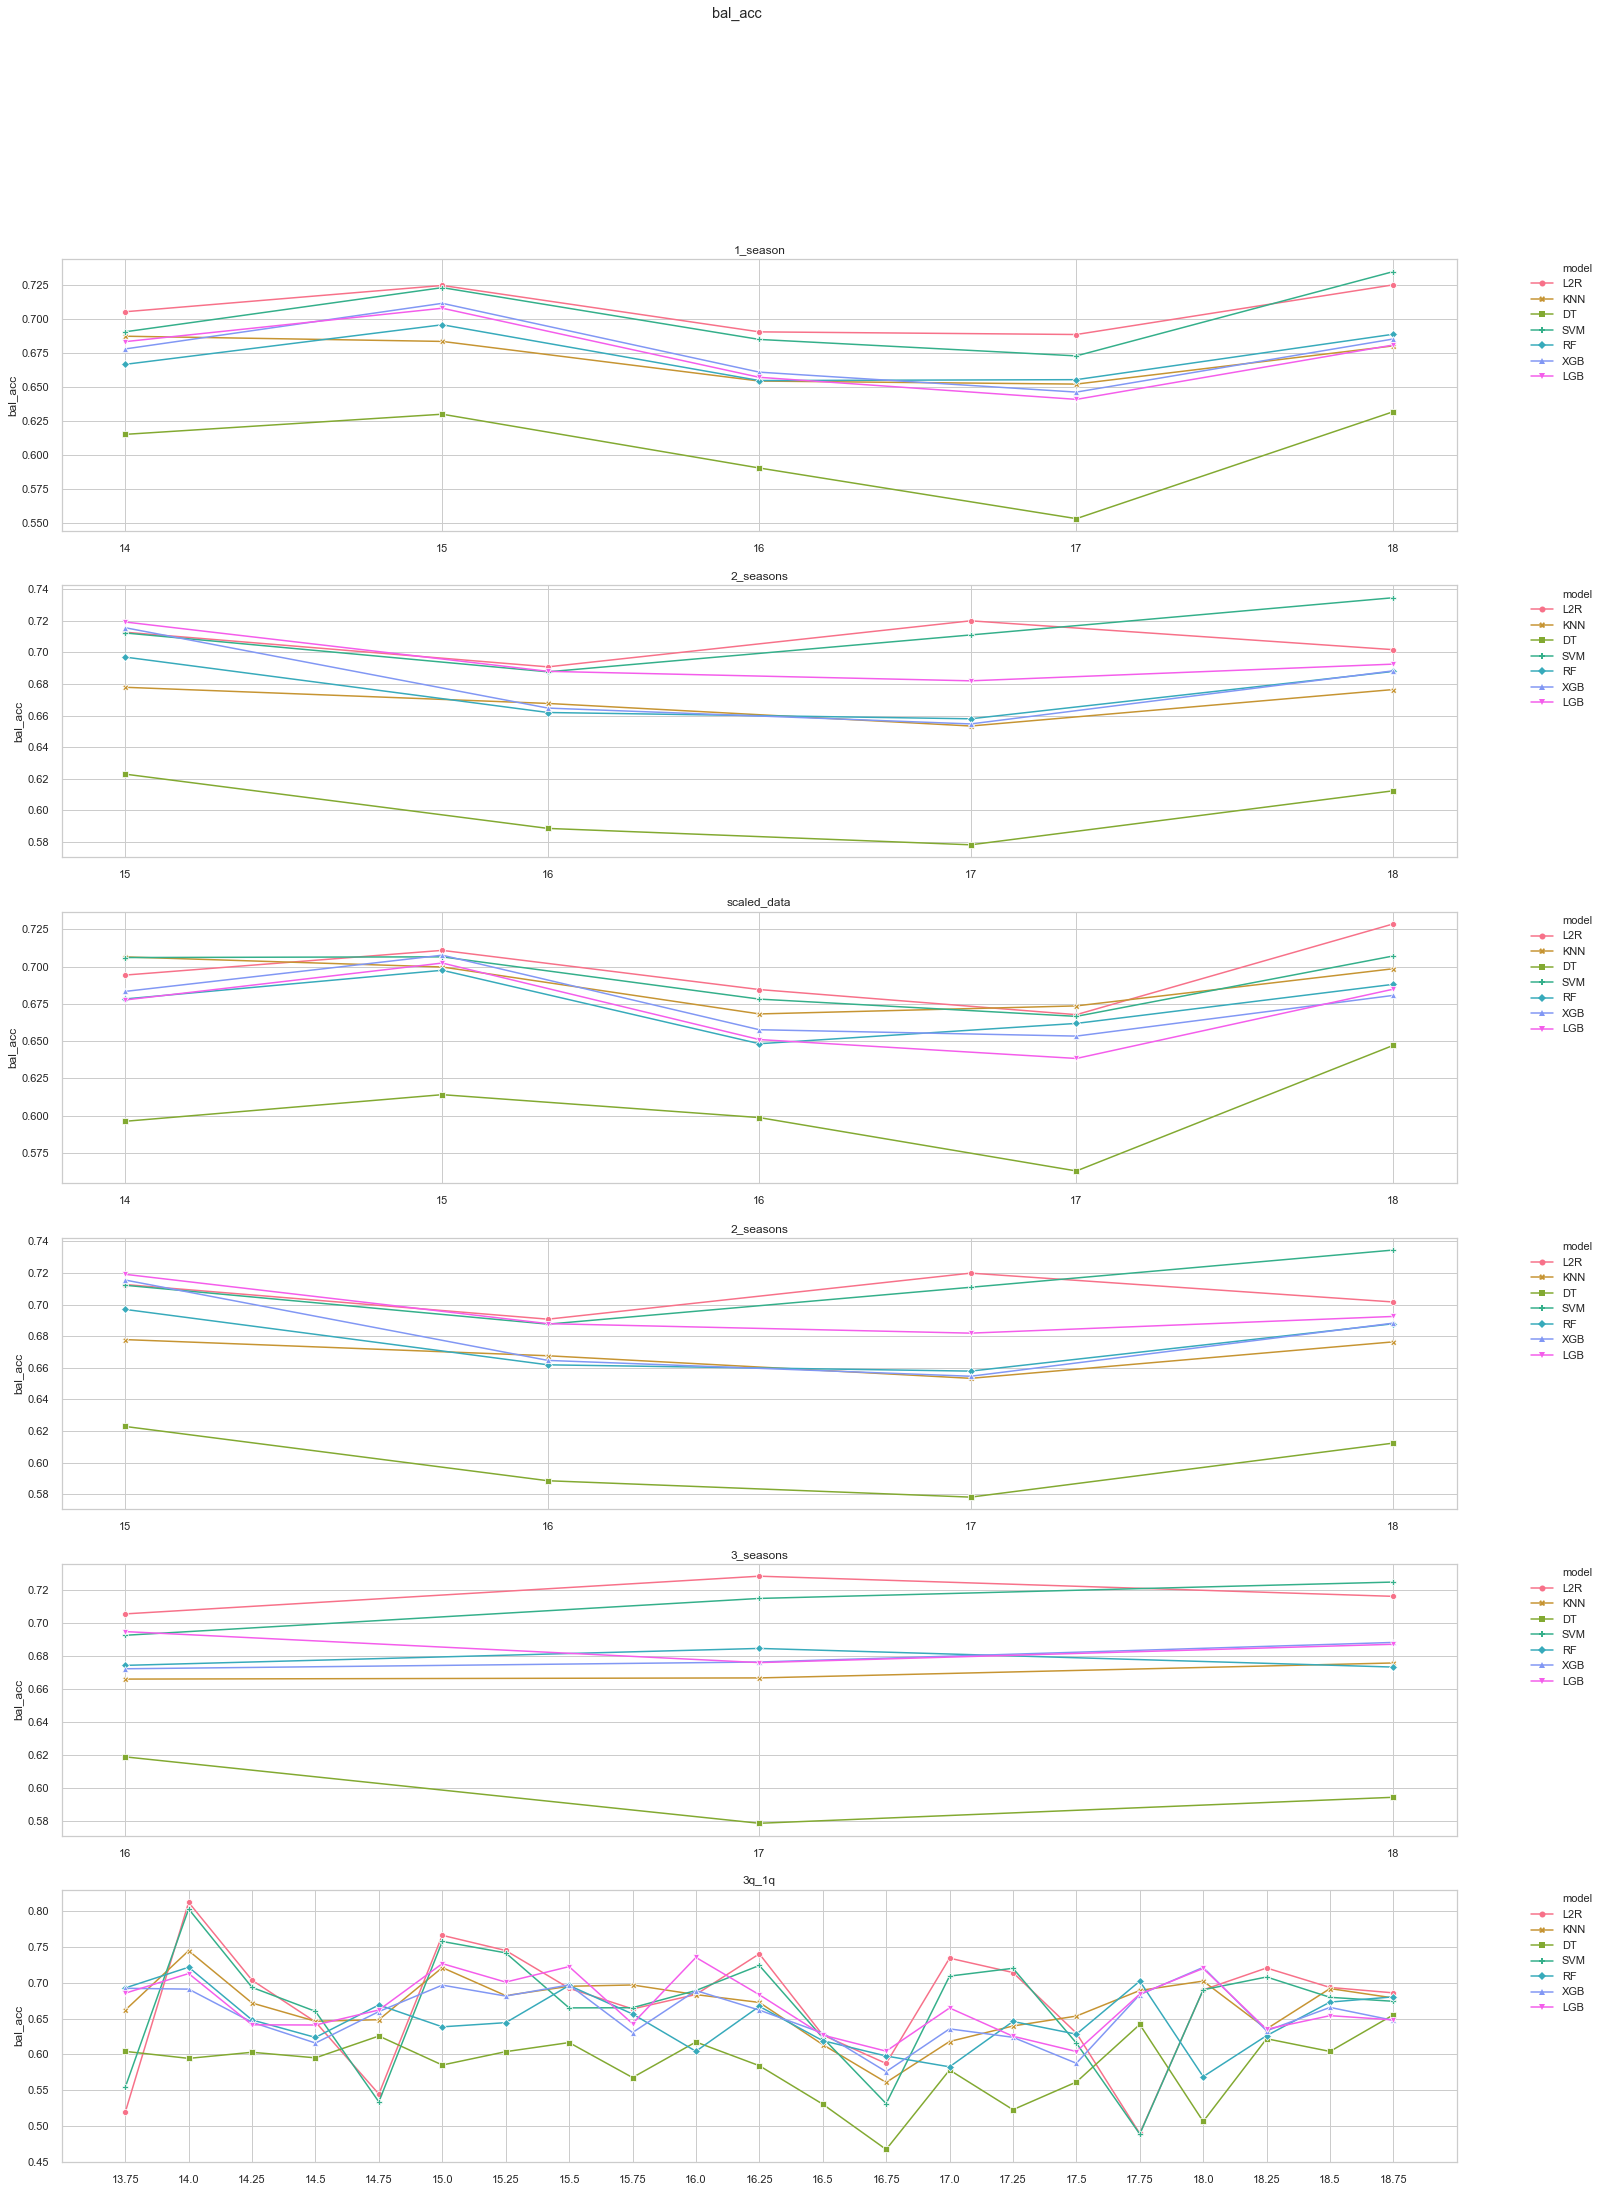

In [22]:
utils.plot_to_compare_experiments(
    results_total,
    metric="bal_acc",
    figsize=(25, 35),
    use_pointplot=True
)

#### Precision

In [ ]:
utils.plot_to_compare_experiments(
    results_total,
    metric="precision",
    figsize=(25, 35),
    use_pointplot=True
)

#### Recall

In [ ]:
utils.plot_to_compare_experiments(
    results_total,
    metric="recall",
    figsize=(25, 35),
    use_pointplot=True
)

#### F1

In [ ]:
utils.plot_to_compare_experiments(
    results_total,
    metric="f1",
    figsize=(25, 35),
    use_pointplot=True
)

#### ROC AUC

In [ ]:
utils.plot_to_compare_experiments(
    results_total,
    metric="roc_auc",
    figsize=(25, 35),
    use_pointplot=True
)